# **imports**

In [1]:
!nvidia-smi

Sat Aug 30 16:35:40 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.03                 Driver Version: 566.03         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 Ti   WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   49C    P0             29W /  165W |    1465MiB /  16380MiB |      2%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
%pip install torchmetrics

Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split, Dataset

import torchvision
from torchvision import datasets
from torchvision import transforms as T
from torchvision.models import vit_b_16 as ViT
from torchvision.models import resnet34 as ResNet34
from torch.utils.data import Dataset
from torchvision.datasets.utils import download_url

import matplotlib.pyplot as plt
from tqdm import tqdm
from torchmetrics import Accuracy
import os
from PIL import Image

# **dataset**

In [4]:
def expand_if_grayscale(x):
    # 如果只有1個channel才expand
    if x.shape[0] == 1:
        return x.expand(3, -1, -1)
    return x

In [ ]:
transforms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Lambda(expand_if_grayscale),
    T.Normalize([0.1307], [0.3081])
])
train_data = datasets.EMNIST(root='EMNIST/raw/train-images-idx3-ubyte', split='balanced', train=True, transform=transforms, download=True)
test_data = datasets.EMNIST(root='EMNIST/raw/test-images-idx3-ubyte', split='balanced', train=False, transform=transforms, download=True)

In [13]:
transforms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Lambda(expand_if_grayscale),
    T.Normalize([0.1307, 0.1307, 0.1307], [0.3081, 0.3081, 0.3081])
])
train_data = datasets.CIFAR100(root='CIFAR100', train=True, transform=transforms, download=True)
test_data = datasets.CIFAR100(root='CIFAR100', train=False, transform=transforms, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
train_data.class_to_idx

{'apple': 0,
 'aquarium_fish': 1,
 'baby': 2,
 'bear': 3,
 'beaver': 4,
 'bed': 5,
 'bee': 6,
 'beetle': 7,
 'bicycle': 8,
 'bottle': 9,
 'bowl': 10,
 'boy': 11,
 'bridge': 12,
 'bus': 13,
 'butterfly': 14,
 'camel': 15,
 'can': 16,
 'castle': 17,
 'caterpillar': 18,
 'cattle': 19,
 'chair': 20,
 'chimpanzee': 21,
 'clock': 22,
 'cloud': 23,
 'cockroach': 24,
 'couch': 25,
 'crab': 26,
 'crocodile': 27,
 'cup': 28,
 'dinosaur': 29,
 'dolphin': 30,
 'elephant': 31,
 'flatfish': 32,
 'forest': 33,
 'fox': 34,
 'girl': 35,
 'hamster': 36,
 'house': 37,
 'kangaroo': 38,
 'keyboard': 39,
 'lamp': 40,
 'lawn_mower': 41,
 'leopard': 42,
 'lion': 43,
 'lizard': 44,
 'lobster': 45,
 'man': 46,
 'maple_tree': 47,
 'motorcycle': 48,
 'mountain': 49,
 'mouse': 50,
 'mushroom': 51,
 'oak_tree': 52,
 'orange': 53,
 'orchid': 54,
 'otter': 55,
 'palm_tree': 56,
 'pear': 57,
 'pickup_truck': 58,
 'pine_tree': 59,
 'plain': 60,
 'plate': 61,
 'poppy': 62,
 'porcupine': 63,
 'possum': 64,
 'rabbit': 65,

In [14]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.34784356..2.516009].


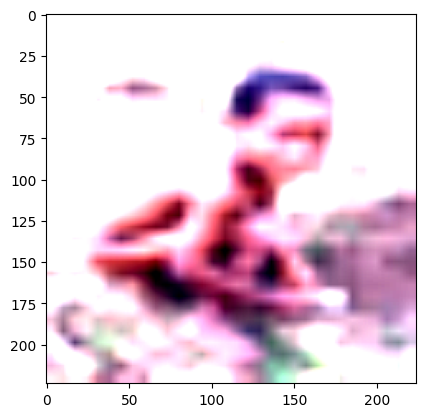

In [15]:
# 取出一個 batch，並取得第一個資料
x, y = next(iter(train_loader))
plt.imshow(x[0].permute(1, 2, 0))

# **ResNet Model**

In [10]:
model = ResNet34(weights=None)
model.fc = nn.Linear(512, 47)  # 修正輸入維度為512，輸出47類
model.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.layer4[0]
model(x).shape

torch.Size([64, 47])

# **VGGnet Model Settings**


In [ ]:
def conv2d_bn_prelu(in_channels, out_channels):
  module = nn.Sequential(nn.Conv2d(in_channels, out_channels, 3, padding=1),
                         nn.BatchNorm2d(out_channels),
                         nn.PReLU())
  return module

In [ ]:
def conv2d_7_bn_prelu(in_channels, out_channels):
  module = nn.Sequential(nn.Conv2d(in_channels, out_channels, 7, padding=3, stride=2),
                         nn.BatchNorm2d(out_channels),
                         nn.PReLU())
  return module

# **VGGnet Model**

In [ ]:
#VGGnet-B (13 weight layers)
model = nn.Sequential(conv2d_7_bn_prelu(1,64),# 128*256  ->  64*128
                      conv2d_bn_prelu(64,64),

                      nn.MaxPool2d(3, stride=2, padding=1),#32*64

                      conv2d_bn_prelu(64,128),
                      conv2d_bn_prelu(128,128),

                      nn.MaxPool2d(kernel_size=2, stride=2),#16*32

                      conv2d_bn_prelu(128,256),
                      conv2d_bn_prelu(256,256),

                      nn.MaxPool2d(kernel_size=2, stride=2),#8*16

                      conv2d_bn_prelu(256,512),
                      conv2d_bn_prelu(512,512),

                      nn.MaxPool2d(kernel_size=3,stride=3, padding=1),#4*6

                      conv2d_bn_prelu(512,512),
                      conv2d_bn_prelu(512,512),

                      nn.AdaptiveAvgPool2d(output_size = (1,1)),
                      nn.Flatten(),
                      nn.Linear(512,47))


In [ ]:
#VGGnet-D (16 weight layers)
model = nn.Sequential(conv2d_7_bn_prelu(1,64),# 128*256  ->  64*128
                      conv2d_bn_prelu(64,64),

                      nn.MaxPool2d(3, stride=2, padding=1),#32*64

                      conv2d_bn_prelu(64,128),
                      conv2d_bn_prelu(128,128),

                      nn.MaxPool2d(2,2),#16*32

                      conv2d_bn_prelu(128,256),
                      conv2d_bn_prelu(256,256),
                      conv2d_bn_prelu(256,256),

                      nn.MaxPool2d(2,2),#8*16

                      conv2d_bn_prelu(256,512),
                      conv2d_bn_prelu(512,512),
                      conv2d_bn_prelu(512,512),

                      nn.MaxPool2d(3,stride=3, padding=1),#4*6

                      conv2d_bn_prelu(512,512),
                      conv2d_bn_prelu(512,512),
                      conv2d_bn_prelu(512,512),

                      nn.AdaptiveAvgPool2d(output_size = (1,1)),
                      nn.Flatten(),
                      nn.Linear(512,47))


In [ ]:
#VGGnet-E (19 weight layers)
model = nn.Sequential(conv2d_7_bn_prelu(1,64),# 128*256  ->  64*128
                      conv2d_bn_prelu(64,64),

                      nn.MaxPool2d(3, stride=2, padding=1),#32*64

                      conv2d_bn_prelu(64,128),
                      conv2d_bn_prelu(128,128),

                      nn.MaxPool2d(2,2),#16*32

                      conv2d_bn_prelu(128,256),
                      conv2d_bn_prelu(256,256),
                      conv2d_bn_prelu(256,256),
                      conv2d_bn_prelu(256,256),

                      nn.MaxPool2d(2,2),#8*16

                      conv2d_bn_prelu(256,512),
                      conv2d_bn_prelu(512,512),
                      conv2d_bn_prelu(512,512),
                      conv2d_bn_prelu(512,512),

                      nn.MaxPool2d(3,stride=3, padding=1),#4*6

                      conv2d_bn_prelu(512,512),
                      conv2d_bn_prelu(512,512),
                      conv2d_bn_prelu(512,512),
                      conv2d_bn_prelu(512,512),

                      nn.AdaptiveAvgPool2d(output_size = (1,1)),
                      nn.Flatten(),
                      nn.Linear(512,47))


# **ViT model**

In [16]:
model = ViT(weights=None)
model.heads.head = nn.Linear(model.heads.head.in_features, 100)
model(x).shape

torch.Size([64, 100])

# **Optimizer**

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, nesterov=True, weight_decay=1e-4)

In [17]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

In [18]:
loss_fn = nn.CrossEntropyLoss()

# **Train**

In [24]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

class AverageMeter(object) :
  def __init__(self):
    self.reset()
  def reset(self) :
    self.avg = 0
    self.val = 0
    self.sum = 0
    self.count = 0
  def update (self, val, n=1) :
    self.val = val
    self.count += n
    self.sum += self.val * n
    self.avg = self.sum / self.count

def train(model, train_loader, optimizer, loss_fn, epoch=None):
  model.train()
  trian_loss = AverageMeter()
  train_acc = Accuracy(task='multiclass', num_classes=100).to(device)
  with tqdm(train_loader, unit='batch') as tepoch :
    for inputs, targets in tepoch:
      if epoch is not None:
        tepoch.set_description(f'Epoch {epoch}')
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, targets)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      trian_loss.update(loss.item())
      train_acc(outputs.argmax(dim=1), targets)

      tepoch.set_postfix(loss=trian_loss.avg,
                         accuracy=100*train_acc.compute().item())
    return model, trian_loss.avg, train_acc.compute()

def evaluate (model, test_loader, loss_fn):
  model.eval()
  with torch.no_grad():
    test_loss = AverageMeter()
    test_acc = Accuracy(task='multiclass', num_classes=100).to(device)
    for n, (inputs, targets) in enumerate(test_loader):
      inputs =  inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, targets)

      test_loss.update(loss)
      test_acc(outputs, targets)
      return test_loss.avg, test_acc.compute()
    

loss_train_hist = []
loss_valid_hist = []

acc_train_hist = []
acc_valid_hist = []

In [25]:
epoch_number = 20

for epoch in range(epoch_number):
  model, train_loss, train_acc = train(model, train_loader, optimizer, loss_fn, epoch)

  test_loss, test_acc = evaluate(model, test_loader, loss_fn)
  loss_train_hist.append(train_loss)
  loss_valid_hist.append(test_loss.to('cpu'))

  acc_train_hist.append(train_acc.to('cpu'))
  acc_valid_hist.append(test_acc.to('cpu'))
  print(f'Test - Loss:{test_loss} - Accuracy:{test_acc}')
  print()

Epoch 0: 100%|██████████| 782/782 [13:04<00:00,  1.00s/batch, accuracy=10.5, loss=3.85]


Test - Loss:3.572573661804199 - Accuracy:0.125



Epoch 1: 100%|██████████| 782/782 [13:09<00:00,  1.01s/batch, accuracy=19.6, loss=3.28]


Test - Loss:3.3022265434265137 - Accuracy:0.171875



Epoch 2: 100%|██████████| 782/782 [13:10<00:00,  1.01s/batch, accuracy=25.9, loss=2.94]


Test - Loss:2.7808430194854736 - Accuracy:0.3125



Epoch 3: 100%|██████████| 782/782 [13:10<00:00,  1.01s/batch, accuracy=31, loss=2.69]  


Test - Loss:2.607841730117798 - Accuracy:0.3125



Epoch 4: 100%|██████████| 782/782 [13:10<00:00,  1.01s/batch, accuracy=35.8, loss=2.46]


Test - Loss:2.5827817916870117 - Accuracy:0.328125



Epoch 5: 100%|██████████| 782/782 [13:10<00:00,  1.01s/batch, accuracy=39.8, loss=2.27]


Test - Loss:2.3105764389038086 - Accuracy:0.328125



Epoch 6: 100%|██████████| 782/782 [13:09<00:00,  1.01s/batch, accuracy=43.7, loss=2.08]


Test - Loss:2.2833521366119385 - Accuracy:0.46875



Epoch 7: 100%|██████████| 782/782 [13:09<00:00,  1.01s/batch, accuracy=48, loss=1.9]   


Test - Loss:1.9952375888824463 - Accuracy:0.515625



Epoch 8: 100%|██████████| 782/782 [13:10<00:00,  1.01s/batch, accuracy=52.6, loss=1.7] 


Test - Loss:2.173025131225586 - Accuracy:0.4375



Epoch 9: 100%|██████████| 782/782 [13:11<00:00,  1.01s/batch, accuracy=57.3, loss=1.51]


Test - Loss:2.3117568492889404 - Accuracy:0.40625



Epoch 10: 100%|██████████| 782/782 [13:09<00:00,  1.01s/batch, accuracy=62.9, loss=1.3] 


Test - Loss:2.455568313598633 - Accuracy:0.421875



Epoch 11: 100%|██████████| 782/782 [13:13<00:00,  1.01s/batch, accuracy=68.5, loss=1.08] 


Test - Loss:2.0147407054901123 - Accuracy:0.515625



Epoch 12: 100%|██████████| 782/782 [13:11<00:00,  1.01s/batch, accuracy=74.7, loss=0.864]


Test - Loss:2.196929931640625 - Accuracy:0.578125



Epoch 13: 100%|██████████| 782/782 [13:09<00:00,  1.01s/batch, accuracy=80.7, loss=0.65] 


Test - Loss:2.40419602394104 - Accuracy:0.46875



Epoch 14: 100%|██████████| 782/782 [13:08<00:00,  1.01s/batch, accuracy=85.8, loss=0.48] 


Test - Loss:2.990471124649048 - Accuracy:0.421875



Epoch 15: 100%|██████████| 782/782 [13:07<00:00,  1.01s/batch, accuracy=89.2, loss=0.37] 


Test - Loss:2.530733823776245 - Accuracy:0.46875



Epoch 16: 100%|██████████| 782/782 [13:10<00:00,  1.01s/batch, accuracy=90.7, loss=0.313]


Test - Loss:2.548137903213501 - Accuracy:0.5



Epoch 17: 100%|██████████| 782/782 [13:10<00:00,  1.01s/batch, accuracy=92.5, loss=0.255]


Test - Loss:2.8081278800964355 - Accuracy:0.453125



Epoch 18: 100%|██████████| 782/782 [13:10<00:00,  1.01s/batch, accuracy=92.6, loss=0.246]


Test - Loss:2.5525989532470703 - Accuracy:0.5



Epoch 19: 100%|██████████| 782/782 [13:13<00:00,  1.01s/batch, accuracy=93.9, loss=0.204]


Test - Loss:2.971754789352417 - Accuracy:0.4375



# **Plot**

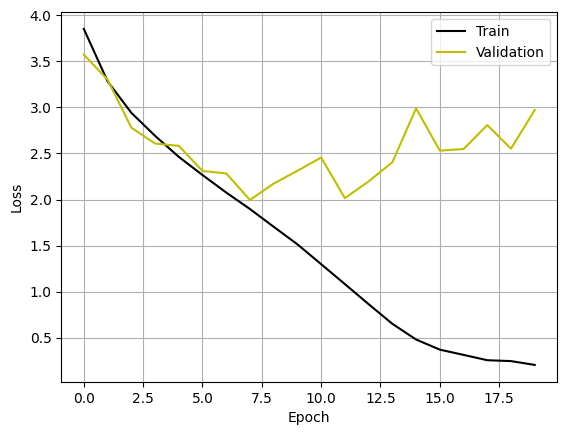

In [26]:
avg_epoch = 20
plt.plot(range(avg_epoch), loss_train_hist, 'k-', label="Train",)
plt.plot(range(avg_epoch), loss_valid_hist, 'y-', label="Validation")

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

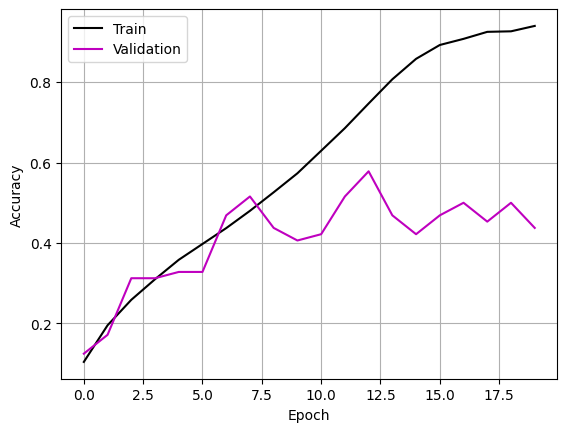

In [27]:
plt.plot(range(avg_epoch), acc_train_hist, 'k-', label='Train')
plt.plot(range(avg_epoch), acc_valid_hist, 'm-', label='Validation',)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [28]:
torch.save(model, 'C:\\Users\\User\\Documents\\GitHub\\Models-Build-1\\vit_b_16-CIFER100-batchsize64-opt=Adam+lr=0.0001.pth')